Using device: cuda
Iteration 10/1000 - Loss: 0.4967149794101715
Iteration 20/1000 - Loss: 0.07617121189832687
Iteration 30/1000 - Loss: -0.34688854217529297
Iteration 40/1000 - Loss: -0.6865014433860779
Iteration 50/1000 - Loss: -0.8314248323440552
Iteration 60/1000 - Loss: -0.8189196586608887
Iteration 70/1000 - Loss: -0.8288313746452332
Iteration 80/1000 - Loss: -0.8344511985778809
Iteration 90/1000 - Loss: -0.8335413932800293
Iteration 100/1000 - Loss: -0.834566593170166
Iteration 110/1000 - Loss: -0.8345572352409363
Iteration 120/1000 - Loss: -0.8346099257469177
Iteration 130/1000 - Loss: -0.8346381187438965
Iteration 140/1000 - Loss: -0.8346314430236816
Iteration 150/1000 - Loss: -0.8346349000930786
Iteration 160/1000 - Loss: -0.8346392512321472
Iteration 170/1000 - Loss: -0.834632396697998
Iteration 180/1000 - Loss: -0.834635853767395
Iteration 190/1000 - Loss: -0.8346415758132935
Iteration 200/1000 - Loss: -0.83464115858078
Iteration 210/1000 - Loss: -0.8346366286277771
Iteratio

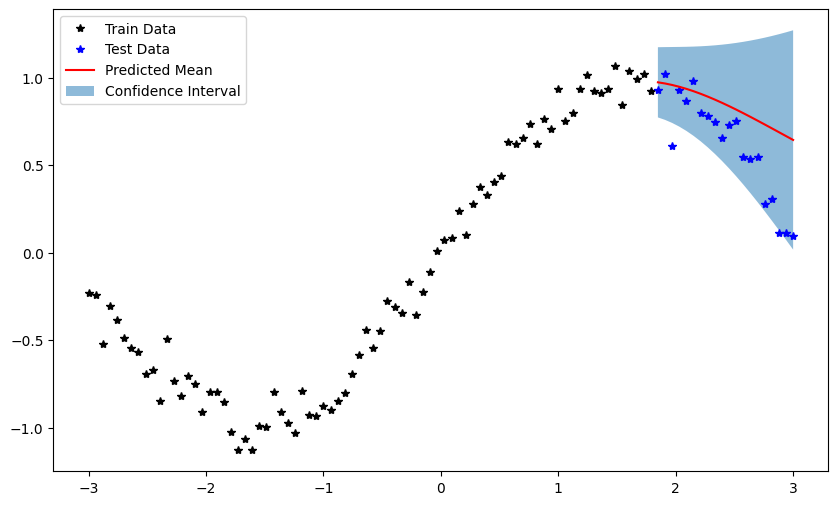

In [5]:
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Generate synthetic data
torch.manual_seed(0)
X = torch.linspace(-3, 3, 100).reshape(-1, 1).to(device)
y = (X.sin() + 0.1 * torch.randn(X.size(), device=device)).to(device)

# Train and test split
train_x = X[:80]
train_y = y[:80].squeeze()  # Ensure train_y is 1-dimensional
test_x = X[80:]
test_y = y[80:].squeeze()  # Ensure test_y is 1-dimensional

# Define the GP model
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = ExactGPModel(train_x, train_y, likelihood).to(device)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 1000
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    if (i + 1) % 10 == 0:
        print(f"Iteration {i+1}/{training_iterations} - Loss: {loss.item()}")
    optimizer.step()

# Make predictions with the model
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))

# Get mean and confidence intervals
mean = observed_pred.mean.cpu()
lower, upper = observed_pred.confidence_region()

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*', label='Train Data')
plt.plot(test_x.cpu().numpy(), test_y.cpu().numpy(), 'b*', label='Test Data')
plt.plot(test_x.cpu().numpy(), mean.numpy(), 'r', label='Predicted Mean')
plt.fill_between(test_x.cpu().numpy().squeeze(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5, label='Confidence Interval')
plt.legend()
plt.show()
